In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from statistics import fmean #, variance
import statistics

import os
import glob
import argparse
import math
import numpy as np

matplotlib.rc('font', family='Times New Roman', serif='cm10')
matplotlib.rc('mathtext', fontset='cm')
plt.rcParams['text.usetex'] = False

examples_per_class = [1,2,4,8,16]
trials = [0,1,2,3]

baselines = {
    "coco": {
        "da": [0.625, 0.7, 0.733, 0.75, 0.775],
        "real_guidance": [0.517, 0.633, 0.70, 0.741, 0.767],
        "rand_aug": [0.467, 0.583, 0.675, 0.732, 0.775]
    },
    "pascal": {
        "da": [0.657, 0.735, 0.764, 0.792, 0.821],
        "real_guidance": [0.593, 0.696, 0.75, 0.796, 0.822],
        "rand_aug": [0.536, 0.657, 0.714, 0.778, 0.821]
    },
    "CalTech101": {
        "da": [0.854, 0.909, 0.922, 0.952, 0.966],
        "real_guidance": [0.841, 0.904, 0.917, 0.945, 0.961],
        "rand_aug": [0.791, 0.868, 0.917, 0.941, 0.966]
    },
    "Flowers102": {
        "da": [0.644, 0.755, 0.833, 0.866, 0.9],
        "real_guidance": [0.5, 0.65, 0.761, 0.844, 0.883],
        "rand_aug": [0.455, 0.633, 0.761, 0.833, 0.902]
    }
}

def format_text(text):
    text = text.replace("_", " ").title()
    return text

In [31]:
def plot_all_cond_methods(dataset_dir, cond_methods):
    examples_per_class = [1,2,4,8,16]
    trials = [0,1,2,3]
    accs = dict()

    for cond_method in cond_methods:
        accs[cond_method] = dict((ex, []) for ex in examples_per_class)
        img_dir = os.path.join(dataset_dir, cond_method)
        run_df = pd.read_csv(os.path.join(img_dir, "results_3_16.csv"), index_col=0)
        # only keep the val accuracy rows (one row per epoch)
        run_df = run_df.loc[(run_df['metric'] == 'Accuracy') & (run_df['split'] == "Validation")]

        for ex in examples_per_class:
            ex_df = run_df.loc[(run_df['examples_per_class'] == ex)]
            for trial in trials:
                trial_df = ex_df.loc[(ex_df['seed'] == trial)]
                val_accs = trial_df["value"].to_numpy()
                acc = val_accs.max()

                accs[cond_method][ex].append(acc)

    # calculate means and stds over trials
    for cond_method in cond_methods:
        for ex in examples_per_class:
                accs[cond_method][ex] = (fmean(accs[cond_method][ex]), statistics.variance(accs[cond_method][ex]))

    # plotting
    plt.figure(figsize=(8, 6))
    for cond_method in accs:
        x = accs[cond_method].keys()
        means = np.array([accs[cond_method][ex][0] for ex in examples_per_class])
        variance = np.array([accs[cond_method][ex][1] for ex in examples_per_class])
        plt.plot(x, means, '--o', label=format_text(cond_method))
        plt.fill_between(x, means-variance, means+variance, alpha=0.2)
    
    plt.legend(prop={'size': 16, 'weight': 'bold'}, loc='lower right')
    plt.xlabel("Examples Per Class", fontsize=24, fontweight='bold', labelpad=12)
    plt.ylabel("Accuracy", fontsize=24, fontweight='bold', labelpad=12)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_tick_params(labelsize=13, color='black')
    plt.gca().xaxis.set_tick_params(labelsize=13, color="black")
    
    dataset = dataset_dir.split('/')[-1] 
    title = f"{dataset.title()} 2.0 CFG Scale" if '10.0cfg' not in dataset else f"{dataset.split('_')[0].title()} 10.0 CFG Scale"
    plt.title(title, fontsize=24, fontweight='bold', pad=12)
    
    plt.grid(color='grey', linestyle='dotted', linewidth=2)
    plt.xticks(examples_per_class, examples_per_class)
    plt.show()
    
    return accs


# plot baselines + our best 
def plot_baselines(accs, best_cond_method, dataset):
    da_fusion = baselines[dataset]["da"]
    real_guidance = baselines[dataset]["real_guidance"]
    rand_aug = baselines[dataset]["rand_aug"]
    our_best = np.array([accs[best_cond_method][ex][0] for ex in examples_per_class])
    stds = np.array([accs[best_cond_method][ex][1] for ex in examples_per_class])
    
    plt.figure(figsize=(8, 6))
    x = examples_per_class
    plt.plot(x, da_fusion, '--o', color='mediumblue', label="DA-Fusion [27]")
    plt.plot(x, real_guidance, '--o', color='firebrick', label="Real Guidance [9]")
    plt.plot(x, rand_aug, '--o', color='deeppink', label="RandAugment [3]")
    plt.plot(x, our_best, '--o', label=f"{format_text(best_cond_method)} (Ours)", color='limegreen')
    plt.fill_between(x, our_best-stds, our_best+stds, alpha=0.2, color='limegreen')
    
    plt.legend(prop={'size': 16, 'weight': 'bold'}, loc='lower right')
    plt.xlabel("Examples Per Class", fontsize=24, fontweight='bold', labelpad=12)
    plt.ylabel("Accuracy", fontsize=24, fontweight='bold', labelpad=12)
    plt.title(dataset.title(), fontsize=24, fontweight='bold', pad=12)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_tick_params(labelsize=13, color='black')
    plt.gca().xaxis.set_tick_params(labelsize=13, color="black")
    
    plt.grid(color='grey', linestyle='dotted', linewidth=2)
    plt.xticks(examples_per_class, examples_per_class)
    plt.show()

# Cond Methods

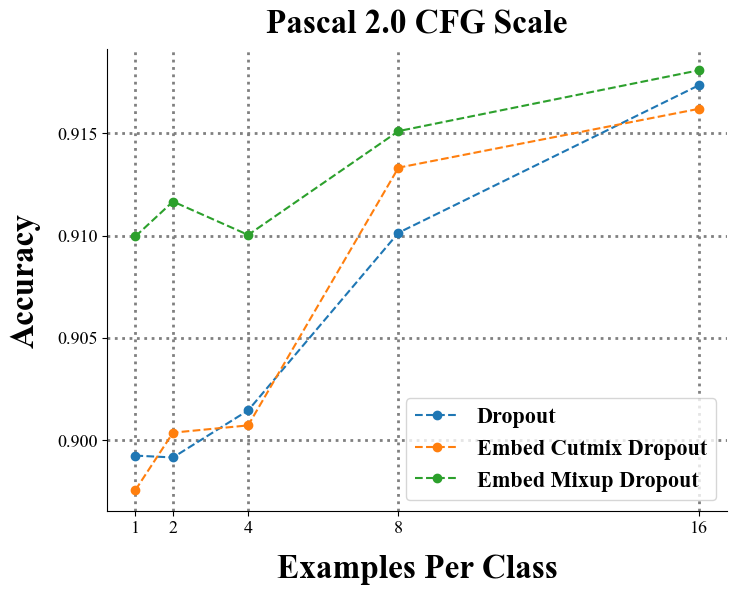

In [23]:
# Pascal 2.0 CFG
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/pascal"
cond_methods = ["dropout", "embed_cutmix_dropout", "embed_mixup_dropout"]
pascal_accs_2cfg = plot_all_cond_methods(dataset_dir, cond_methods)

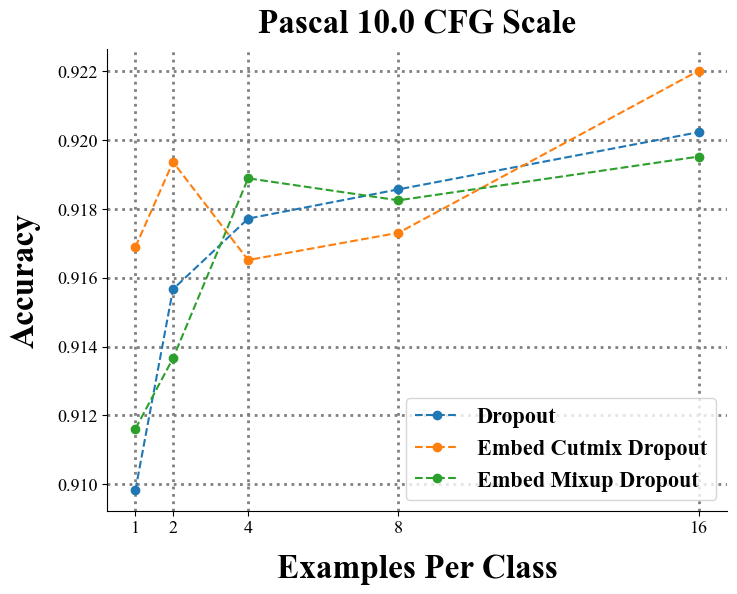

In [24]:
# Pascal 10.0 CFG
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/pascal_10.0cfg"
pascal_accs_10cfg = plot_all_cond_methods(dataset_dir, cond_methods)

## Pascal Best: 10.0CFG Embed Cutmix Dropout

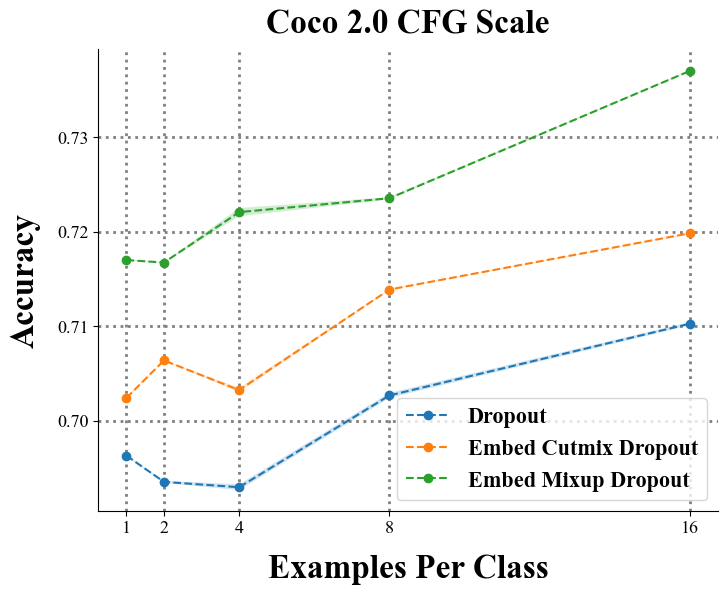

In [25]:
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/coco"
coco_accs_2cfg = plot_all_cond_methods(dataset_dir, cond_methods)

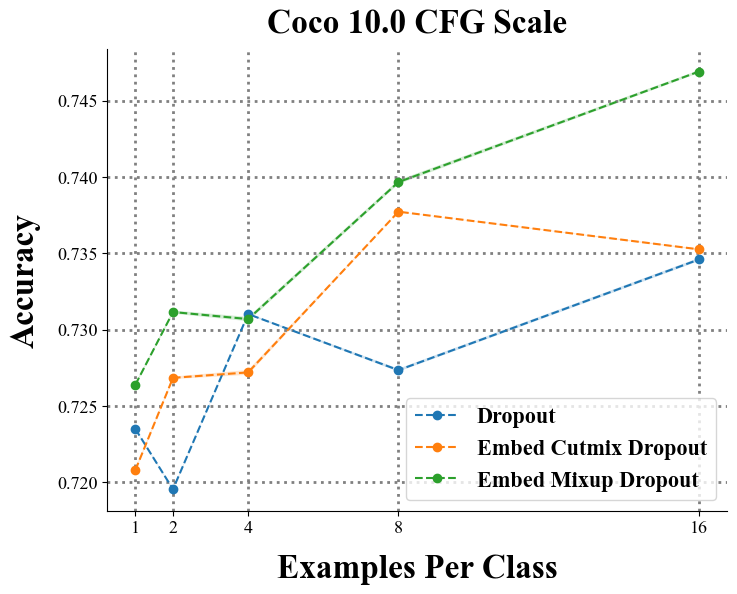

In [26]:
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/coco_10.0cfg"
coco_accs_10cfg = plot_all_cond_methods(dataset_dir, cond_methods)

## COCO Best: 10.0CFG Embed Mixup Dropout

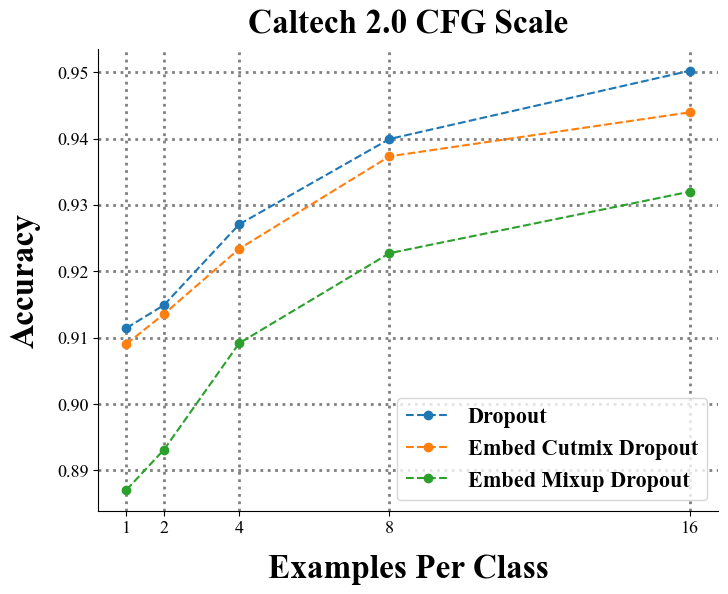

In [27]:
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/caltech"
caltech_accs_2cfg = plot_all_cond_methods(dataset_dir, cond_methods)

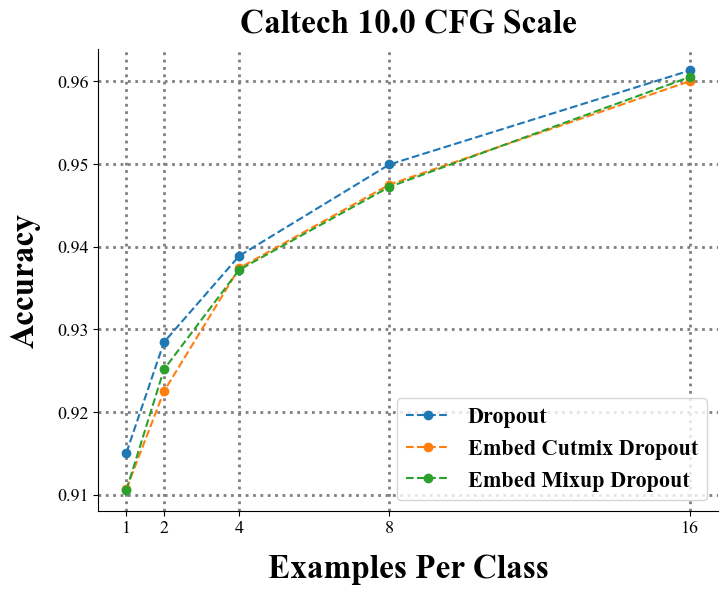

In [28]:
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/caltech_10.0cfg"
caltech_accs_10cfg = plot_all_cond_methods(dataset_dir, cond_methods)

## Caltech Best: Dropout 10.0CFG

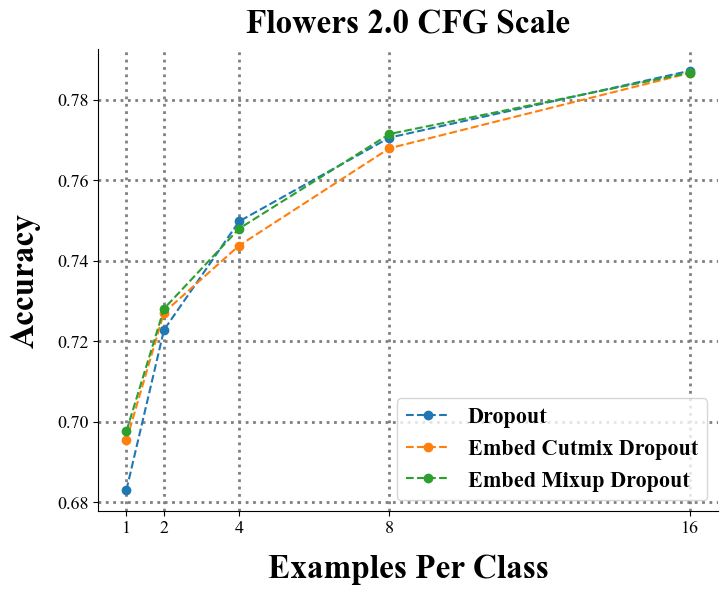

In [29]:
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/flowers"
flowers_accs_2cfg = plot_all_cond_methods(dataset_dir, cond_methods)

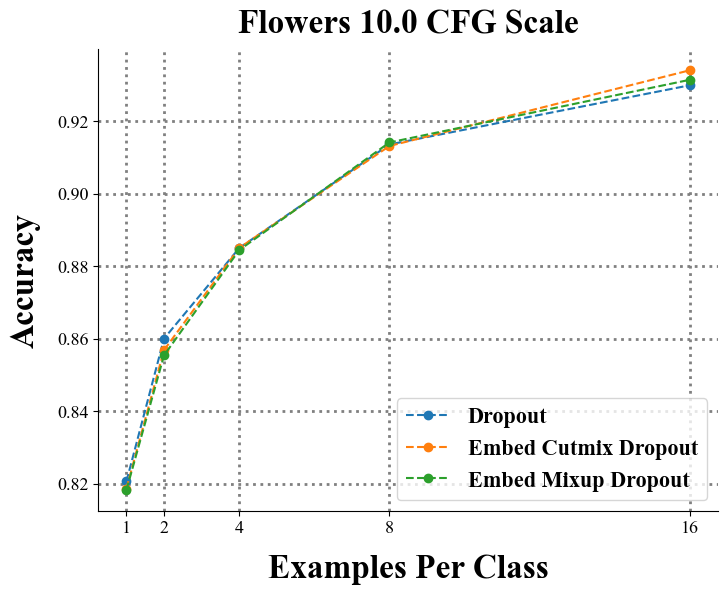

In [30]:
dataset_dir = "/datastor1/jiahuikchen/LT-classification/logs/flowers_10.0cfg"
flowers_accs_10cfg = plot_all_cond_methods(dataset_dir, cond_methods)

## Flowers Best: 10.0CFG Embed Cutmix Dropout (10% difference between CFGs...)

# Baselines

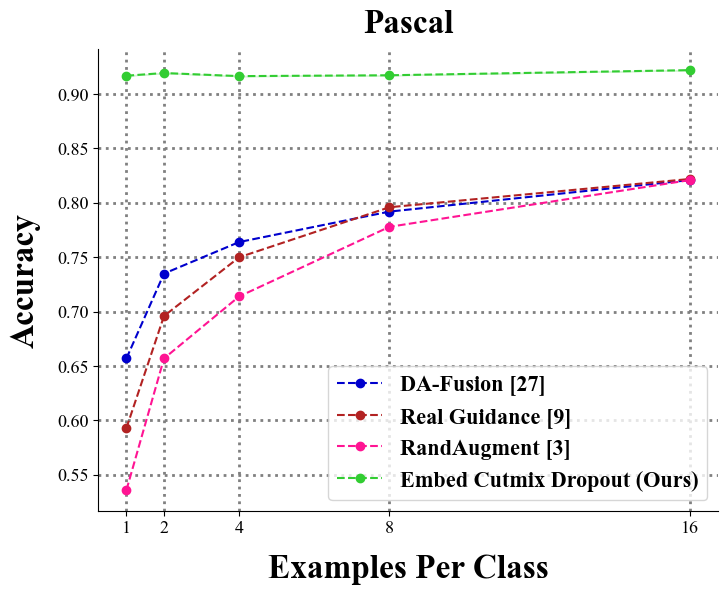

In [32]:
plot_baselines(pascal_accs_10cfg, "embed_cutmix_dropout", "pascal")

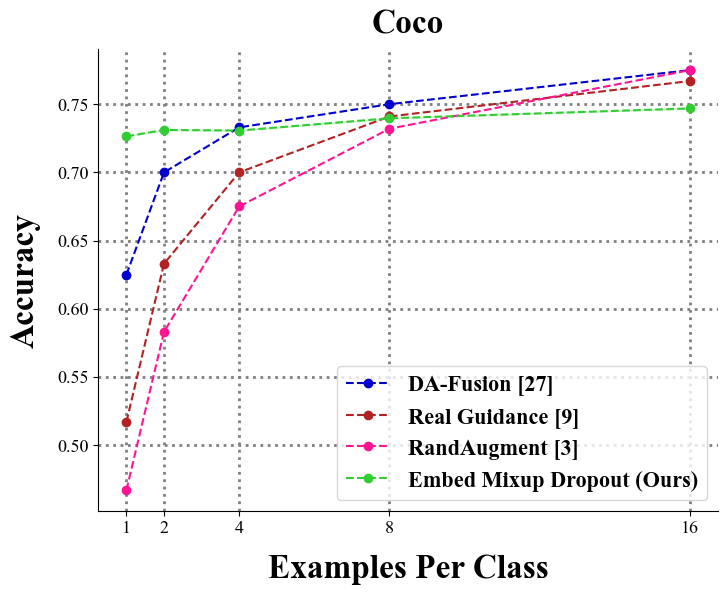

In [33]:
plot_baselines(coco_accs_10cfg, "embed_mixup_dropout", "coco")

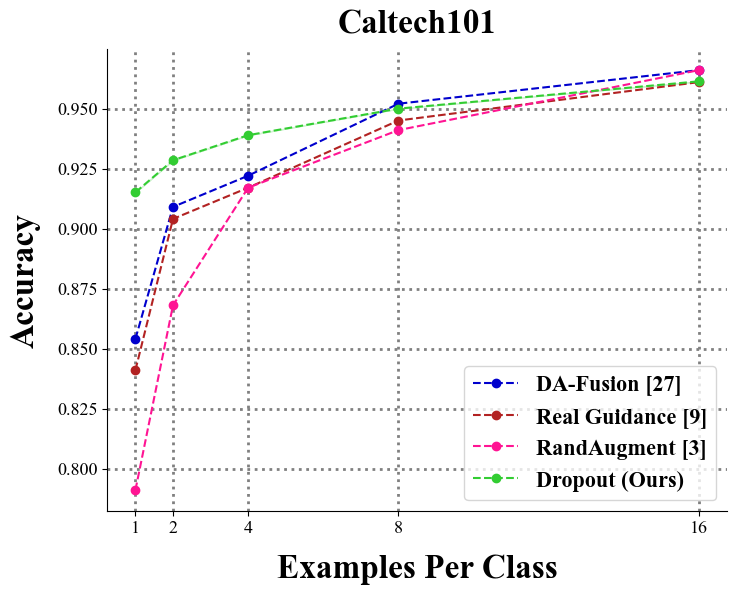

In [34]:
plot_baselines(caltech_accs_10cfg, "dropout", "CalTech101")

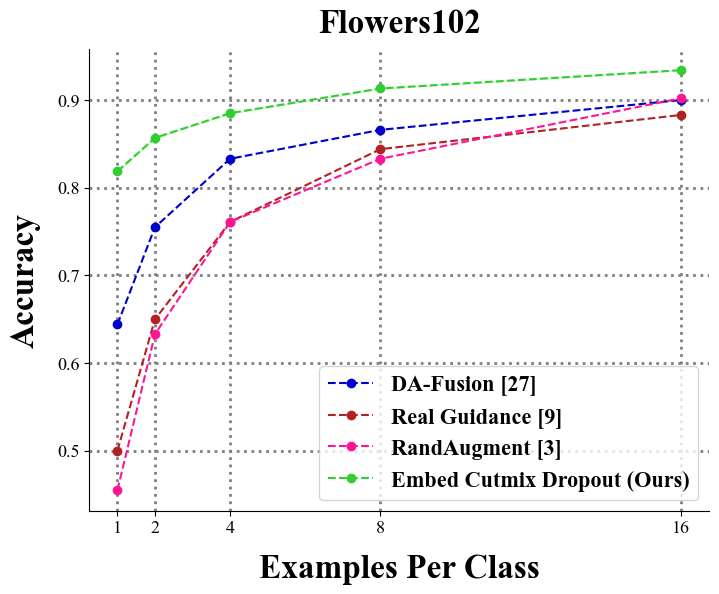

In [35]:
plot_baselines(flowers_accs_10cfg, "embed_cutmix_dropout", "Flowers102")

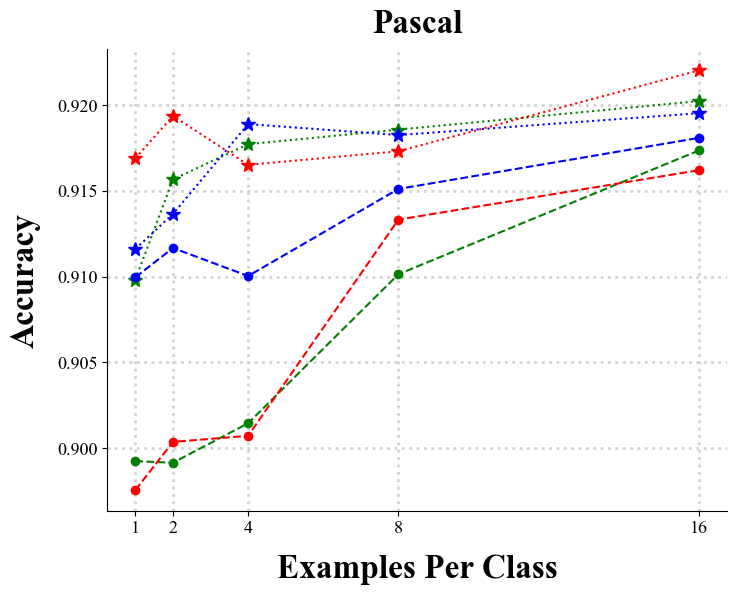

In [49]:
# plot different CFG all on one plot for pascal
pascal_accs = [(pascal_accs_10cfg, '10'), (pascal_accs_2cfg, '2')]

plt.figure(figsize=(8, 6))
for accs, cfg in pascal_accs:
    for cond_method in accs:
        x = accs[cond_method].keys()
        means = np.array([accs[cond_method][ex][0] for ex in examples_per_class])
        variance = np.array([accs[cond_method][ex][1] for ex in examples_per_class])
        if "cutmix" in cond_method:
            color = 'r'
        elif "mixup" in cond_method:
            color = 'b'
        else:
            color = 'g'
        if cfg == '10':
            plt.plot(x, means, ':*', label=f"{format_text(cond_method)} 10.0 CFG", color=color, markersize=10)
        else:
            plt.plot(x, means, '--o', label=f"{format_text(cond_method)} 2.0 CFG", color=color)
        plt.fill_between(x, means-variance, means+variance, alpha=0.2)

# plt.legend(prop={'size': 16, 'weight': 'bold'}, loc='lower right', framealpha=1.0)
plt.xlabel("Examples Per Class", fontsize=24, fontweight='bold', labelpad=12)
plt.ylabel("Accuracy", fontsize=24, fontweight='bold', labelpad=12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_tick_params(labelsize=13, color='black')
plt.gca().xaxis.set_tick_params(labelsize=13, color="black")

dataset = dataset_dir.split('/')[-1] 
plt.title("Pascal", fontsize=24, fontweight='bold', pad=12)

plt.grid(color='lightgrey', linestyle='dotted', linewidth=2)
plt.xticks(examples_per_class, examples_per_class)
plt.show()

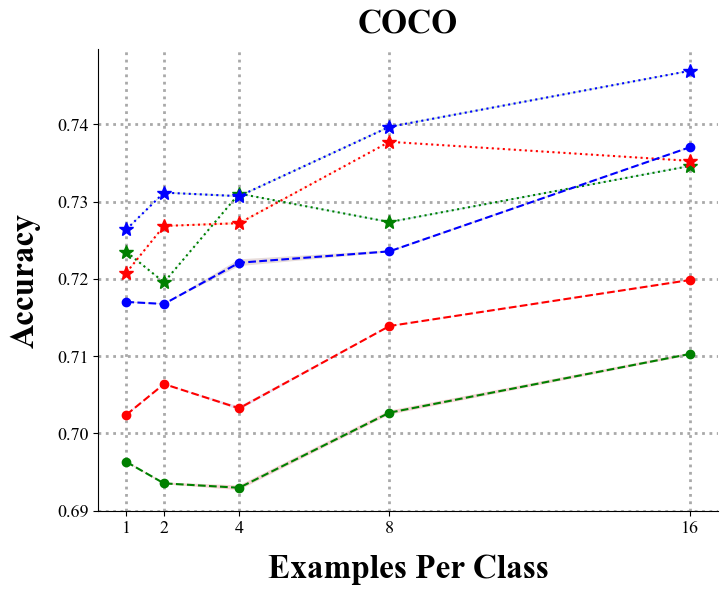

In [47]:
# plot different CFG all on one plot for pascal
pascal_accs = [(coco_accs_10cfg, '10'), (coco_accs_2cfg, '2')]

plt.figure(figsize=(8, 6))
for accs, cfg in pascal_accs:
    for cond_method in accs:
        x = accs[cond_method].keys()
        means = np.array([accs[cond_method][ex][0] for ex in examples_per_class])
        variance = np.array([accs[cond_method][ex][1] for ex in examples_per_class])
        if "cutmix" in cond_method:
            color = 'r'
        elif "mixup" in cond_method:
            color = 'b'
        else:
            color = 'g'
        if cfg == '10':
            plt.plot(x, means, ':*', label=f"{format_text(cond_method)} 10.0 CFG", color=color, markersize=10)
        else:
            plt.plot(x, means, '--o', label=f"{format_text(cond_method)} 2.0 CFG", color=color)
        plt.fill_between(x, means-variance, means+variance, alpha=0.2)

# plt.legend(prop={'size': 14, 'weight': 'bold'}, loc='lower right')
plt.xlabel("Examples Per Class", fontsize=24, fontweight='bold', labelpad=12)
plt.ylabel("Accuracy", fontsize=24, fontweight='bold', labelpad=12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_tick_params(labelsize=13, color='black')
plt.gca().xaxis.set_tick_params(labelsize=13, color="black")

dataset = dataset_dir.split('/')[-1] 
plt.title("COCO", fontsize=24, fontweight='bold', pad=12)

plt.grid(color='darkgrey', linestyle='dotted', linewidth=2)
plt.xticks(examples_per_class, examples_per_class)
plt.show()

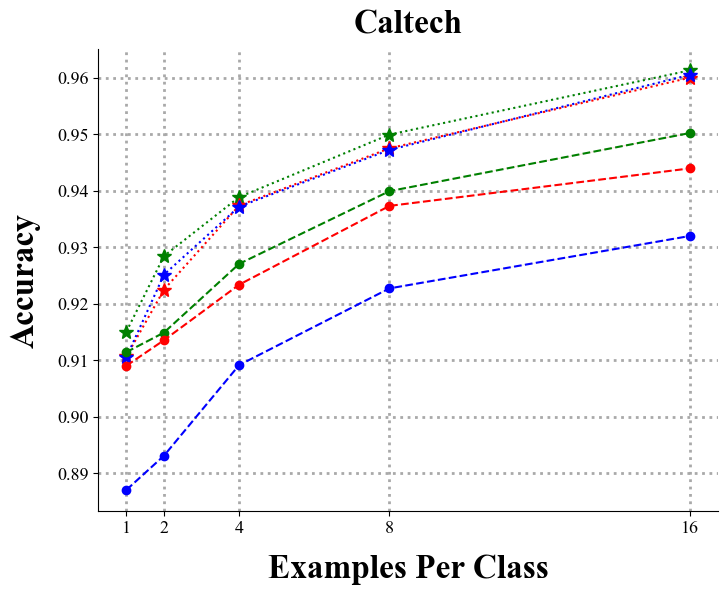

In [44]:
# plot different CFG all on one plot for pascal
pascal_accs = [(caltech_accs_10cfg, '10'), (caltech_accs_2cfg, '2')]

plt.figure(figsize=(8, 6))
for accs, cfg in pascal_accs:
    for cond_method in accs:
        x = accs[cond_method].keys()
        means = np.array([accs[cond_method][ex][0] for ex in examples_per_class])
        variance = np.array([accs[cond_method][ex][1] for ex in examples_per_class])
        if "cutmix" in cond_method:
            color = 'r'
        elif "mixup" in cond_method:
            color = 'b'
        else:
            color = 'g'
        if cfg == '10':
            plt.plot(x, means, ':*', label=f"{format_text(cond_method)} 10.0 CFG", color=color, markersize=10)
        else:
            plt.plot(x, means, '--o', label=f"{format_text(cond_method)} 2.0 CFG", color=color)
        plt.fill_between(x, means-variance, means+variance, alpha=0.2)

# plt.legend(prop={'size': 14, 'weight': 'bold'}, loc='lower right')
plt.xlabel("Examples Per Class", fontsize=24, fontweight='bold', labelpad=12)
plt.ylabel("Accuracy", fontsize=24, fontweight='bold', labelpad=12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_tick_params(labelsize=13, color='black')
plt.gca().xaxis.set_tick_params(labelsize=13, color="black")

dataset = dataset_dir.split('/')[-1] 
plt.title("Caltech", fontsize=24, fontweight='bold', pad=12)

plt.grid(color='darkgrey', linestyle='dotted', linewidth=2)
plt.xticks(examples_per_class, examples_per_class)
plt.show()

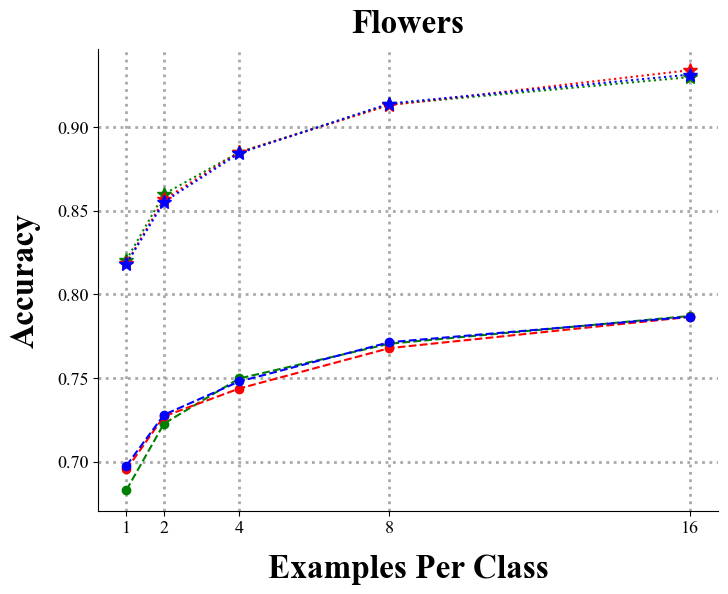

In [45]:
# plot different CFG all on one plot for pascal
pascal_accs = [(flowers_accs_10cfg, '10'), (flowers_accs_2cfg, '2')]

plt.figure(figsize=(8, 6))
for accs, cfg in pascal_accs:
    for cond_method in accs:
        x = accs[cond_method].keys()
        means = np.array([accs[cond_method][ex][0] for ex in examples_per_class])
        variance = np.array([accs[cond_method][ex][1] for ex in examples_per_class])
        if "cutmix" in cond_method:
            color = 'r'
        elif "mixup" in cond_method:
            color = 'b'
        else:
            color = 'g'
        if cfg == '10':
            plt.plot(x, means, ':*', label=f"{format_text(cond_method)} 10.0 CFG", color=color, markersize=10)
        else:
            plt.plot(x, means, '--o', label=f"{format_text(cond_method)} 2.0 CFG", color=color)
        plt.fill_between(x, means-variance, means+variance, alpha=0.2)

# plt.legend(prop={'size': 14, 'weight': 'bold'}, loc='lower right')
plt.xlabel("Examples Per Class", fontsize=24, fontweight='bold', labelpad=12)
plt.ylabel("Accuracy", fontsize=24, fontweight='bold', labelpad=12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_tick_params(labelsize=13, color='black')
plt.gca().xaxis.set_tick_params(labelsize=13, color="black")

dataset = dataset_dir.split('/')[-1] 
plt.title("Flowers", fontsize=24, fontweight='bold', pad=12)

plt.grid(color='darkgrey', linestyle='dotted', linewidth=2)
plt.xticks(examples_per_class, examples_per_class)
plt.show()